# Advanced Information Retrieval - Group Project

## Authors
* Felix Moitzi
* David Rainer
* Michael Unterberger

## Short Description

Training two Bi-Encoder to create similar encodings for Queries and similar Documents. One using only positive samples and the other incorporating Negative sampling. Afterwards the Bi-Encoders will be used to build basic, fast and scalable IR-Engines, the performance of which will be tested.

## Notes For the Boyz

### Dataset

* Kleine Beschreibung zum Dataset: https://ir-datasets.com/cranfield.html
* Weitere Datasets die wir in Zukunft vllt. stattdessen verwenden/hinzufügen können: https://ir-datasets.com/index.html

* Für den Anfang ist ein Binary-Approach (1 = relevant, 0 = irrelevant) das beste
* Meine recommendation Werte 4 und 3 sind positiv/relevant, -1 und 1 sind negativ/irrelevant, Label 2 müssen wir noch besprechen
* Aufbereiten der Daten für Negative Sampling in der Form: Query, Relevantes Doc, Irrelevantes Doc
* Aufbereiten der Daten für Normales trainin

* Should def. use dropout


In [ ]:
!pip install ir_datasets
!pip install faiss-gpu

## Imports

In [ ]:

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import ir_datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import faiss
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import os

#initialize gpu if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
from google.colab import drive

# mount google drive so save model parameters later
drive.mount('/content/drive')

# Create a folder in the root directory
!mkdir -p "/content/drive/My Drive/My Folder"

Mounted at /content/drive


In [ ]:
import random

def progress_bar(progress, total):
    percent = 100 * (progress / float(total))
    bar_length = int(percent)
    bar = ''

    # ANSI escape codes for some rainbow colors
    colors = colors = [
    '\033[31m', # Red
    '\033[32m', # Green
    '\033[33m', # Yellow
    '\033[34m', # Blue
    '\033[35m', # Magenta
    '\033[36m', # Cyan
    '\033[91m', # Bright Red
    '\033[92m', # Bright Green
    '\033[93m', # Bright Yellow
    '\033[94m', # Bright Blue
    '\033[95m', # Bright Magenta
    '\033[96m', # Bright Cyan
    ]

    # Create the bar with random colors
    for i in range(bar_length):
        bar += random.choice(colors) + '█'
    bar += '\033[0m'  # Reset color to default

    bar += '-' * (100 - bar_length)

    if percent >= 100:
        print(f"\r|{bar}| {percent:.2f}%", end="\n")
    else:
        print(f"\r|{bar}| {percent:.2f}%", end="", flush=True)

## Load Dataset & Preprocessing

In [ ]:
dataset = ir_datasets.load("cranfield")

In [ ]:

def getQrels(relevance_threshold, dataset):
    positive_qrels = []
    negative_qrels = []
    for qrel in dataset.qrels_iter():
        if qrel.relevance > relevance_threshold:
            positive_qrels.append(qrel)
        if qrel.relevance < relevance_threshold:
            negative_qrels.append(qrel)

    return positive_qrels, negative_qrels

def getPositiveData(positive_qrels):
    pos_train = []
    pos_eval = []
    pos_test = []

    number_positive_qrels = len(positive_qrels)
    print(f"Number of positive qrels: {number_positive_qrels}")
    ten_percent_pos = int(number_positive_qrels / 10)

    used_indices = []
    for _ in range(ten_percent_pos):
        rand = np.random.randint(0, number_positive_qrels)
        while rand in used_indices:
            rand = np.random.randint(0, number_positive_qrels)
        pos_eval.append(positive_qrels[rand])
        used_indices.append(rand)

        rand = np.random.randint(0, number_positive_qrels)
        while rand in used_indices:
            rand = np.random.randint(0, number_positive_qrels)
        pos_test.append(positive_qrels[rand])
        used_indices.append(rand)

    for i in range(0, number_positive_qrels):
        if i not in used_indices:
            pos_train.append(positive_qrels[i])

    #print("Length of pos_train:", len(pos_train))
    #print("Length of pos_eval:", len(pos_eval))
    #print("Length of pos_test:", len(pos_test))

    return pos_train, pos_eval, pos_test

def getNegativeData(negative_qrels):
    neg_train = []
    neg_eval = []
    neg_test = []

    number_negative_qrels = len(negative_qrels)
    print(f"Number of negative qrels: {number_negative_qrels}")
    ten_percent_neg = int(number_negative_qrels / 10)

    used_indices = []
    for _ in range(ten_percent_neg):
        rand = np.random.randint(0, number_negative_qrels)
        while rand in used_indices:
            rand = np.random.randint(0, number_negative_qrels)
        neg_eval.append(negative_qrels[rand])
        used_indices.append(rand)

        rand = np.random.randint(0, number_negative_qrels)
        while rand in used_indices:
            rand = np.random.randint(0, number_negative_qrels)
        neg_test.append(negative_qrels[rand])
        used_indices.append(rand)

    for i in range(0, number_negative_qrels):
        if i not in used_indices:
            neg_train.append(negative_qrels[i])

    #print("Length of neg_train:", len(neg_train))
    #print("Length of neg_eval:", len(neg_eval))
    #print("Length of neg_test:", len(neg_test))

    return neg_train, neg_eval, neg_test


def loadDocuments(ds):
    dict = {}
    for doc in ds.docs_iter():
        dict[int(doc.doc_id)] = doc.text
    return dict

def loadQueries(ds):
    dict = {}
    for query in ds.queries_iter():
        dict[int(query.query_id)] = query.text
    return dict

def checkIfInPositives(neg_doc_ids, pos_doc_ids):
    for n in neg_doc_ids:
        if n in pos_doc_ids:
            return True
    return False


# returns dict with query id as key and list of tuples with pos and negative doc ids as values
def getPositiveNegativeDocIDs(processed_queries, processed_documents, pos_train_qrel, neg_train_qrel):
    data = {} # for every query id where are positive samples, samples with positive and negative docs

    # get positive query_id/doc_id pairs
    positive_query_id_doc_ids = {}
    for e in pos_train_qrel:
        query_id = int(e.query_id)
        doc_id = int(e.doc_id)
        if query_id not in processed_queries.keys() or doc_id not in processed_documents.keys():
            continue
        if query_id not in positive_query_id_doc_ids.keys():
            positive_query_id_doc_ids[query_id] = []
        positive_query_id_doc_ids[query_id].append(doc_id)
    #print(positive_query_id_doc_ids)


    # get negative query_id/doc_id pairs
    negative_query_id_doc_ids = {}
    for e in neg_train_qrel:
        query_id = int(e.query_id)
        doc_id = int(e.doc_id)
        if query_id not in processed_queries.keys() or doc_id not in processed_documents.keys():
            continue
        if query_id not in negative_query_id_doc_ids.keys():
            negative_query_id_doc_ids[query_id] = []
        negative_query_id_doc_ids[query_id].append(doc_id)
    #print(negative_query_id_doc_ids)

    for pos_query_id in positive_query_id_doc_ids.keys():
        data[pos_query_id] = []

        pos_doc_ids = positive_query_id_doc_ids[pos_query_id]
        if pos_query_id not in negative_query_id_doc_ids.keys(): # random sampling for positive query ids where no negative docs exist

            random_index = np.random.randint(0, len(negative_query_id_doc_ids.keys()))
            neg_doc_ids = negative_query_id_doc_ids[list(negative_query_id_doc_ids.keys())[random_index]]

            while checkIfInPositives(neg_doc_ids, pos_doc_ids):
                print("Found neg id in positives")
                random_index = np.random.randint(0, len(negative_query_id_doc_ids.keys()))
                neg_doc_ids = negative_query_id_doc_ids[list(negative_query_id_doc_ids.keys())[random_index]]

        else:
            neg_doc_ids = negative_query_id_doc_ids[pos_query_id]

        for i in range(0, len(pos_doc_ids)):
            pos_doc_id = pos_doc_ids[i]

            # adding random sampling for negative doc
            neg_index = np.random.randint(0, len(neg_doc_ids))
            neg_doc_id = neg_doc_ids[neg_index]
            data[pos_query_id].append((pos_doc_id, neg_doc_id))
    return data

def convertMapToListTriples(map):
    return_list = []
    for key in map.keys():
        query_id = key
        for e in map[key]:
            return_list.append((query_id, e[0], e[1]))
    return return_list





In [ ]:
positive_qrels, negative_qrels = getQrels(2, dataset)
pos_train_qrel, pos_eval_qrel, pos_test_qrel = getPositiveData(positive_qrels)
neg_train_qrel, neg_eval_qrel, neg_test_qrel = getNegativeData(negative_qrels)
documents = loadDocuments(dataset)
queries = loadQueries(dataset)

[INFO] [starting] http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz
[INFO] [finished] http://ir.dcs.gla.ac.uk/resources/test_collections/cran/cran.tar.gz: [00:00] [507kB] [705kB/s]


Number of positive qrels: 1097
Number of negative qrels: 353


In [ ]:
class CranfieldDatasetPOS_NEG(Dataset):
    def __init__(self, queries, documents, pos_qrel, neg_qrel):
        self.queries = queries
        self.documents = documents
        self.query_idx_pos_neg_doc_ids_map = getPositiveNegativeDocIDs(queries, documents, pos_qrel, neg_qrel)
        self.tripples_list = convertMapToListTriples(self.query_idx_pos_neg_doc_ids_map)
        print(f"Dataloader initialized with {len(self.query_idx_pos_neg_doc_ids_map.keys())} query ids")

    def __len__(self):
        return len(self.tripples_list)

    def __getitem__(self, idx):
        entry = self.tripples_list
        query = self.queries[entry[idx][0]]
        positive_doc = self.documents[entry[idx][1]]
        negative_doc = self.documents[entry[idx][2]]

        return query, positive_doc, negative_doc

class CranfieldDatasetPOS(Dataset):
    def __init__(self, queries, documents, pos_qrel, neg_qrel):
        self.queries = queries
        self.documents = documents
        self.query_idx_pos_neg_doc_ids_map = getPositiveNegativeDocIDs(queries, documents, pos_qrel, neg_qrel)
        self.tripples_list = convertMapToListTriples(self.query_idx_pos_neg_doc_ids_map)
        print(f"Dataloader initialized with {len(self.query_idx_pos_neg_doc_ids_map.keys())} query ids")

    def __len__(self):
        return len(self.tripples_list)

    def __getitem__(self, idx):
        entry = self.tripples_list
        query = self.queries[entry[idx][0]]
        positive_doc = self.documents[entry[idx][1]]

        return query, positive_doc



## Create the Datasets

In [ ]:
cranfield_dataset_pos = CranfieldDatasetPOS(queries, documents, pos_train_qrel, neg_train_qrel)
cranfield_dataset_pos_neg = CranfieldDatasetPOS_NEG(queries, documents, pos_train_qrel, neg_train_qrel)

cranfield_dataset_pos_eval = CranfieldDatasetPOS(queries, documents, pos_eval_qrel, neg_eval_qrel)
cranfield_dataset_pos_neg_eval = CranfieldDatasetPOS_NEG(queries, documents, pos_eval_qrel, neg_eval_qrel)

cranfield_dataset_pos_test = CranfieldDatasetPOS(queries, documents, pos_test_qrel, neg_test_qrel)
cranfield_dataset_pos_neg_test = CranfieldDatasetPOS_NEG(queries, documents, pos_test_qrel, neg_test_qrel)

Dataloader initialized with 132 query ids
Dataloader initialized with 132 query ids
Dataloader initialized with 50 query ids
Found neg id in positives
Dataloader initialized with 50 query ids
Dataloader initialized with 55 query ids
Dataloader initialized with 55 query ids


## Create the Model

This is one Branch of the Bi-Encoder Structure.
It...

* Encodes the input-sentence using a tokenizer
*

In [ ]:
from transformers import DistilBertModel, DistilBertTokenizer
#from transformers import BertModel, BertTokenizer

'''
class BertEncoder(torch.nn.Module):
    def __init__(self, model_name):
        super(BertEncoder, self).__init__()
        self.encoder = BertModel.from_pretrained(model_name)
        self.tokenizer = BertTokenizer.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.encoder(input_ids=input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids)
        # Use the pooled output
        pooled_output = outputs.pooler_output
        return pooled_output

    def encode(self, text, max_length=512):
        inputs = self.tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        inputs = {key: value.to(device) for key, value in inputs.items()}
        return self.forward(**inputs)
'''

class DistilBertEncoder(torch.nn.Module):
    def __init__(self, model_name):
        super(DistilBertEncoder, self).__init__()
        self.encoder = DistilBertModel.from_pretrained(model_name)
        self.tokenizer = DistilBertTokenizer.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        # Mean pooling
        token_embeddings = outputs.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
        #return outputs.last_hidden_state[:, 0, :]  # Get cls token representation -> acts as aggregate of sequence information

    def encode(self, text, max_length=512):
        inputs = self.tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        inputs = {key: value.to(device) for key, value in inputs.items()}
        return self.forward(**inputs)


## Set up Training-utilities

### Create Combined Optimizers for the Encoder Pairs

It is necessary to optimize both encoders of the Bi-Encoder architecture at the same time. So in the first step we take the parameters of the query- and document-encoder and combine them into a list, which will be passed to the optimizer constructor.

### Define Standard Similarity Loss Function
* query_embeddings: Embeddings for the queries.
* positive_embeddings: Embeddings for the positive documents.

returns Mean loss for the batch.

In [ ]:
def positive_samples_loss(query_embeddings, positive_embeddings):

    # Cosine similarity between query and positive samples
    similarity = F.cosine_similarity(query_embeddings, positive_embeddings)

    # the goal is to make the similarity as close to 1 as possible
    # so we minimize the mean squared error from 1
    loss = F.mse_loss(similarity, torch.ones_like(similarity))

    return loss

### Define Contrastive Loss Function
Calculate contrastive loss using cosine similarity.
    
* query_embeddings: Embeddings for the query.
* positive_embeddings: Embeddings for the positive documents.
* negative_embeddings: Embeddings for the negative documents.
* margin: Margin by which positive and negative pairs should be separated.

returns Mean contrastive loss over the batch.

In [ ]:
def contrastive_loss(query_embeddings, positive_embeddings, negative_embeddings, margin=0.2):
    # Cosine similarity between query and positive samples
    pos_similarity = F.cosine_similarity(query_embeddings, positive_embeddings)

    # Cosine similarity between query and negative samples
    neg_similarity = F.cosine_similarity(query_embeddings, negative_embeddings)

    doc_similarity = F.cosine_similarity(positive_embeddings, negative_embeddings)

    # Loss calculation: Maximize pos_similarity and minimize neg_similarity
    # We want pos_similarity to be high, and neg_similarity to be low
    # neg_similarity + margin <= pos_similarity -> loss = 0
    losses = F.sigmoid(neg_similarity + margin - pos_similarity + doc_similarity)

    return losses.mean()

In [ ]:
def triplet_loss(query_embeddings, positive_embeddings, negative_embeddings, margin=0.2):
    """
    Compute the triplet loss.

    Parameters:
    - query_embeddings: Tensor of query embeddings
    - positive_embeddings: Tensor of embeddings of documents relevant to the queries
    - negative_embeddings: Tensor of embeddings of documents not relevant to the queries
    - margin: A scalar margin for triplet loss (default is 1.0)

    Returns:
    - A scalar representing the mean triplet loss over the batch
    """

    # Calculate pairwise distances
    positive_distance = (query_embeddings - positive_embeddings).pow(2).sum(1)
    negative_distance = (query_embeddings - negative_embeddings).pow(2).sum(1)

    # Compute loss
    losses = positive_distance - negative_distance + margin
    loss = losses.clamp(min=0).mean()  # Clamp negative losses to 0 and calculate mean
    return loss


## Training Loops

### Only Positive Training & Test Loop

In [ ]:
def train_pos(dataloader, q_enc, doc_enc, loss_function, optimizer):
  q_enc.train()
  doc_enc.train()
  total_loss = 0


  print("Train loop")
  for idx, batch in enumerate(dataloader):
    progress_bar(idx, len(dataloader))
    # batch contains queries positive docs
    queries, pos_docs = batch

    # encoding
    query_embeddings = q_enc.encode(queries)
    pos_doc_embeddings = doc_enc.encode(pos_docs)

    # compute contrastive loss
    loss = loss_function(query_embeddings, pos_doc_embeddings)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  averaged_loss = total_loss / len(dataloader)
  progress_bar(1, 1)
  print(f"Loss: {averaged_loss}")
  print("\n")

In [ ]:
def test_pos(dataloader, q_enc, doc_enc, loss_function):
  q_enc.eval()
  doc_enc.eval()

  total_loss = 0
  print("Test loop")
  with torch.no_grad():
    for idx, batch in enumerate(dataloader):
      progress_bar(idx, len(dataloader))
      queries, pos_docs = batch

      q_emb = q_enc.encode(queries)
      doc_emb = doc_enc.encode(pos_docs)

      loss = loss_function(q_emb, doc_emb)
      total_loss += loss.item()
    progress_bar(1, 1)
    averaged_loss = total_loss / len(dataloader)
    print(f"Loss: {averaged_loss}")
    print("\n")
  return averaged_loss

### Contrastive Architecture Training & Test loop (negative samples)

In [ ]:
def train_neg(dataloader, q_enc, doc_enc, loss_function, optimizer):
  q_enc.train()
  doc_enc.train()

  total_loss = 0

  print("Train loop")
  for idx, batch in enumerate(dataloader):
    progress_bar(idx, len(dataloader))
    # batch contains queries, positive docs, and negative docs
    queries, pos_docs, neg_docs = batch

    # encoding
    query_embeddings = q_enc.encode(queries)
    pos_doc_embeddings = doc_enc.encode(pos_docs)
    neg_doc_embeddings = doc_enc.encode(neg_docs)

    # compute contrastive loss
    loss = loss_function(query_embeddings, pos_doc_embeddings, neg_doc_embeddings)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  averaged_loss = total_loss / len(dataloader)
  progress_bar(1, 1)
  print(f"Loss: {averaged_loss}")
  print("\n")

In [ ]:
def test_neg(dataloader, q_enc, doc_enc, loss_function):
  q_enc.eval()
  doc_enc.eval()

  total_loss = 0
  print("Test loop")
  with torch.no_grad():
    for idx, batch in enumerate(dataloader):
      progress_bar(idx, len(dataloader))
      queries, pos_docs, neg_docs = batch

      q_emb = q_enc.encode(queries)
      pos_doc_emb = doc_enc.encode(pos_docs)
      neg_doc_emb = doc_enc.encode(neg_docs)

      loss = loss_function(q_emb, pos_doc_emb, neg_doc_emb)
      total_loss += loss.item()
    progress_bar(1, 1)
    averaged_loss = total_loss / len(dataloader)
    print(f"Loss: {averaged_loss}")
    print("\n")
  return averaged_loss

## Full Training & Test Loops

In [ ]:
epochs = 4
learning_rate = 0.01
batch_size = 1

#model_name = "bert-base-cased"
model_name = "distilbert-base-uncased"

In [ ]:
query_encoder = 0
document_encoder = 0
query_encoder = DistilBertEncoder(model_name)
document_encoder = DistilBertEncoder(model_name)

combined_parameters_pos = list(query_encoder.parameters()) +  list(document_encoder.parameters())
optimizer_only_positives = torch.optim.Adam(combined_parameters_pos, lr=learning_rate)

cranfield_dataloader_only_positives = DataLoader(cranfield_dataset_pos, batch_size=batch_size, shuffle=True)
cranfield_dataloader_only_positives_eval = DataLoader(cranfield_dataset_pos_eval, batch_size=batch_size, shuffle=True)
cranfield_dataloader_only_positives_test = DataLoader(cranfield_dataset_pos_test, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
query_encoder.eval()
document_encoder.eval()

query_encoder.to(device)
document_encoder.to(device)

num_elements_to_inspect = 2
count = 0

for data in cranfield_dataloader_only_positives:
  # Process your data or do something with it
  # ...
  queries, pos_docs = data
  print(tuple((queries[0][:100], )))
  print(tuple((pos_docs[0][:100], )))

  print(query_encoder.encode(queries)[0,:8].tolist())
  print(document_encoder.encode(pos_docs)[0,:8].tolist())
  count += 1
  if count >= num_elements_to_inspect:
    break

query_encoder.to('cpu')
document_encoder.to('cpu')
torch.cuda.empty_cache()

('will forward or apex located controls be effective at low subsonic\nspeeds and how do they compare wi',)
('a small deflection theory for curved sandwich plates .\n  a small-deflection theory that takes into a',)
[-0.26015621423721313, 0.07670549303293228, 0.23669232428073883, 0.3044404685497284, 0.013503472320735455, -0.20957744121551514, -0.05652497336268425, -0.07393177598714828]
[-0.23046012222766876, -0.012325674295425415, 0.11098913848400116, -0.06042644754052162, 0.12034977227449417, 0.017696034163236618, -0.29892969131469727, 0.14179900288581848]
('has anyone investigated the unsteady lift distributions on finite\nwings in subsonic flow .',)
('stress and displacement analysis of simply supported\nnon- circular cylindrical shell under lateral p',)
[-0.3247060179710388, -0.24555647373199463, 0.073624387383461, 0.030793773010373116, -0.058627039194107056, -0.21282105147838593, -0.27859795093536377, 0.10502070933580399]
[-0.40398550033569336, -0.01362516451627016, 0.22686520218849

In [ ]:
print("Training the first Architecture on only positives\n")

query_encoder.to(device)
document_encoder.to(device)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train_pos(cranfield_dataloader_only_positives, query_encoder, document_encoder, positive_samples_loss, optimizer_only_positives)
    test_pos(cranfield_dataloader_only_positives_eval, query_encoder, document_encoder, positive_samples_loss)
print("Done!")
test_pos(cranfield_dataloader_only_positives_test, query_encoder, document_encoder, positive_samples_loss)

query_encoder.to('cpu')
document_encoder.to('cpu')
torch.cuda.empty_cache()

Training the first Architecture on only positives

Epoch 1
-------------------------------
Train loop
|███████████████████████████-------------------------------------------------------------------------| 27.92%

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

query_encoder_ns = 0
document_encoder_ns = 0
query_encoder_ns = DistilBertEncoder(model_name)
document_encoder_ns = DistilBertEncoder(model_name)

combined_parameters_ns = list(query_encoder_ns.parameters()) +  list(document_encoder_ns.parameters())
optimizer_negative_sampling = torch.optim.Adam(combined_parameters_ns, lr=learning_rate)

cranfield_dataloader = DataLoader(cranfield_dataset_pos_neg, batch_size=batch_size, shuffle=True)
cranfield_dataloader_eval = DataLoader(cranfield_dataset_pos_neg_eval, batch_size=batch_size, shuffle=True)
cranfield_dataloader_test = DataLoader(cranfield_dataset_pos_neg_test, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
query_encoder_ns.to(device)
document_encoder_ns.to(device)

query_encoder_ns.eval()
document_encoder_ns.eval()

num_elements_to_inspect = 2
count = 0

query_embeddings = []
pos_doc_embeddings = []
neg_doc_embeddings = []

for data in cranfield_dataloader:
    # Process your data or do something with it
    # ...
    queries, pos_docs, neg_docs = data
    print(tuple((queries[0][:100], )))
    print(tuple((pos_docs[0][:100], )))
    print(tuple((neg_docs[0][:100], )))

    print(query_encoder_ns.encode(queries)[0,:8].tolist())
    print(document_encoder_ns.encode(pos_docs)[0,:8].tolist())
    print(document_encoder_ns.encode(neg_docs)[0,:8].tolist())

    query_embeddings.append(query_encoder_ns.encode(queries).detach().cpu().numpy())
    pos_doc_embeddings.append(document_encoder_ns.encode(pos_docs).detach().cpu().numpy())
    neg_doc_embeddings.append(document_encoder_ns.encode(neg_docs).detach().cpu().numpy())

    count += 1
    if count >= num_elements_to_inspect:
        break

query_encoder_ns.to('cpu')
document_encoder_ns.to('cpu')
torch.cuda.empty_cache()

('how can the effect of the boundary-layer on wing pressure be calculated,\nand what is its magnitude .',)
('the problem of obtaining high lift-drag ratios at supersonic speeds .\nthe importance of the lift to ',)
('factors affecting lift-drag ratios at mach numbers\nfrom 5 to 20 .\n  yawed-cone working charts and an',)
[-0.027332942932844162, -0.08380597829818726, 0.03669675439596176, 0.1021343395113945, 0.03578334301710129, -0.1420031487941742, -0.032796405255794525, -0.0382327139377594]
[-0.34257394075393677, 0.12716616690158844, 0.3066047430038452, 0.010909232310950756, 0.12319497019052505, 0.005325502250343561, 0.07721095532178879, 0.08416236191987991]
[-0.32431045174598694, -0.001157684950158, 0.32122376561164856, 0.11539521813392639, 0.1215834692120552, 0.06270729005336761, -0.07179046422243118, -0.08403115719556808]
('has anyone investigated and developed a simple model for the vortex\nwake behind a cruciform wing .',)
('laminar heat transfer over blunt-nosed bodies at hyperson

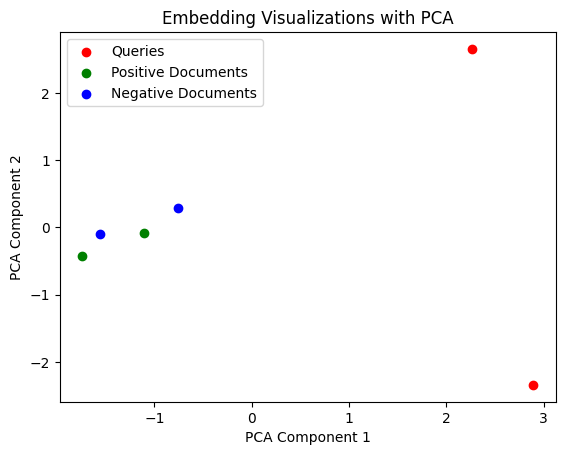

In [ ]:
# for plot


pca = PCA(n_components=2)
all_embeddings = np.concatenate([np.concatenate(query_embeddings),np.concatenate(pos_doc_embeddings),np.concatenate(neg_doc_embeddings)])
pca.fit(all_embeddings)

queries_2d = pca.transform(np.concatenate(query_embeddings))
pos_docs_2d = pca.transform(np.concatenate(pos_doc_embeddings))
neg_docs_2d = pca.transform(np.concatenate(neg_doc_embeddings))

# Plotting
plt.scatter(queries_2d[:, 0], queries_2d[:, 1], color='red', label='Queries')
plt.scatter(pos_docs_2d[:, 0], pos_docs_2d[:, 1], color='green', label='Positive Documents')
plt.scatter(neg_docs_2d[:, 0], neg_docs_2d[:, 1], color='blue', label='Negative Documents')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Embedding Visualizations with PCA')
plt.legend()
plt.show()


In [ ]:
print("Training the second Architecture with negative sampling\n")

query_encoder_ns.to(device)
document_encoder_ns.to(device)

for e in range(epochs):
    print(f"Epoch {e+1}\n-------------------------------")
    train_neg(cranfield_dataloader, query_encoder_ns, document_encoder_ns, triplet_loss, optimizer_negative_sampling)
    test_neg(cranfield_dataloader_eval, query_encoder_ns, document_encoder_ns, triplet_loss)
print("Done!")
test_neg(cranfield_dataloader_test, query_encoder_ns, document_encoder_ns,  triplet_loss)

query_encoder_ns.to('cpu')
document_encoder_ns.to('cpu')
torch.cuda.empty_cache()

In [ ]:
query_encoder.eval()
document_encoder.eval()

query_encoder.to(device)
document_encoder.to(device)

num_elements_to_inspect = 2
count = 0

for data in cranfield_dataloader_only_positives:
  # Process your data or do something with it
  # ...
  queries, pos_docs = data
  print(tuple((queries[0][:100], )))
  print(tuple((pos_docs[0][:100], )))

  print(query_encoder.encode(queries)[0,:8].tolist())
  print(document_encoder.encode(pos_docs)[0,:8].tolist())
  count += 1
  if count >= num_elements_to_inspect:
    break

query_encoder.to('cpu')
document_encoder.to('cpu')
torch.cuda.empty_cache()

In [ ]:
query_encoder_ns.to(device)
document_encoder_ns.to(device)

query_encoder_ns.eval()
document_encoder_ns.eval()

num_elements_to_inspect = 2
count = 0

query_embeddings = []
pos_doc_embeddings = []
neg_doc_embeddings = []

for data in cranfield_dataloader:
    # Process your data or do something with it
    # ...
    queries, pos_docs, neg_docs = data
    print(tuple((queries[0][:100], )))
    print(tuple((pos_docs[0][:100], )))
    print(tuple((neg_docs[0][:100], )))

    print(query_encoder_ns.encode(queries)[0,:8].tolist())
    print(document_encoder_ns.encode(pos_docs)[0,:8].tolist())
    print(document_encoder_ns.encode(neg_docs)[0,:8].tolist())

    query_embeddings.append(query_encoder_ns.encode(queries).detach().cpu().numpy())
    pos_doc_embeddings.append(document_encoder_ns.encode(pos_docs).detach().cpu().numpy())
    neg_doc_embeddings.append(document_encoder_ns.encode(neg_docs).detach().cpu().numpy())

    count += 1
    count += 1
    if count >= num_elements_to_inspect:
        break

query_encoder_ns.to('cpu')
document_encoder_ns.to('cpu')
torch.cuda.empty_cache()

# Hyperparameter tuning


In [ ]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'epochs': [2, 5, 10],
    'margin': [0.1, 0.2, 0.5],
    #'batch_size': [16, 32, 64],
}

for params in ParameterGrid(param_grid):
    epochs = params['epochs']
    learning_rate = params['learning_rate']
    margin = params['margin']

    print(f"\nCurrent Parameters: Epochs: {epochs}, Learning Rate: {learning_rate}, Batch Size: {batch_size}")



FAISS KNN-IDX

Info for the bois

Faiss is a library developed by Facebook AI Research (FAIR) for efficient similarity search and clustering of dense vectors. It contains algorithms that are especially useful for searching in large collections of vectors. The term "KNN-IDX" in the context of Faiss typically refers to the process or mechanism for performing k-Nearest Neighbors (KNN) searches within an indexed dataset.

In [ ]:
from transformers import DistilBertConfig

config = DistilBertConfig.from_pretrained(model_name)
model = DistilBertModel(config)

# Initialize FAISS
pos_d = config.dim
neg_d = config.dim

embeddings_pos = None
embeddings_neg = None

index_pos = faiss.IndexFlatL2(pos_d)
index_pos.add(embeddings_pos)

index_neg = faiss.IndexFlatL2(neg_d)
index_neg.add(embeddings_neg)